Final Project

Alex Chiaramonte

Cole Moses



There are many factors that play into determining the value of a house. Our group is interested in seeing if we can determine this value using some of the classifiers we have learned over the course of the semester. There is a lot of value to be had in being able to determine the value of a house in todays business climate as predicting the value of a house can lead to substantial profit or loss depending on how good the prediction is.
Our preliminary thinking was using linear regression, nearest neighbor,ridge regression with polynomial features, and possibly random forest. Our data set however, lead us down a different path.


Our group found a data set that looked at the houses in an area of Wisconsin that had almost 20 features and 7146 samples. This data included a continuous label which would make this a regression problem. The dataset had files ranging from 2002 housing data to 2022. We decided to use only the 2022 sales data as it was the most recent data and would exclude issues like inflation when trying to predict house values. This data included features that would be useful to us as well as not so useful. PropertyID is a feature that has no context other than an assigned ID to the property. A couple more examples include taxkey, Address, CondoProject, nbhd, and Sale_date. These features would later be removed.




In [2]:
#both added libraries as needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


Here, we are importing all the necessary libraries we will use during the project

CELL FOR USING DRIVE

In [6]:
from google.colab import drive
drive.mount("/content/drive")
PATH = "/content/drive/MyDrive/CS345_Final_Project/archive/2022-property-sales-data.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CELL TO RUN THE NOTEBOOK WITH LOCAL DATA

In [4]:
PATH = "./2022-property-sales-data.csv"

In [7]:
data = pd.read_csv(PATH).values
data[:3,:]

array([[98461, 'Manufacturing', 30131000, '9434-9446 N 107TH ST', nan, 9,
        6300, 'Service Building', 'Concrete Block', 1.0, 1978.0, nan,
        20600.0, 6, nan, 0, 0, 0, '2022-04-01', 950000.0],
       [98464, 'Commercial', 30152000, '9306-9316 N 107TH ST', nan, 9,
        6202, 'Office Building - 1 Story', 'Brick', 1.0, 1982.0, nan,
        9688.0, 23, nan, 0, 0, 35719, '2022-10-07', 385000.0],
       [98508, 'Residential', 49980110, '9327 N SWAN RD', nan, 9, 40,
        nan, nan, nan, nan, nan, nan, 0, nan, 0, 0, 1341648,
        '2022-01-07', 800000.0]], dtype=object)

The cells above we are just setting up the notebook. We set up the notebook to use the datafiles in our shared drive folder. This was what we came up with to allow us to both work on the notebook together. IF THE NOTEBOOK IS BEING RUN LOCALLY RUN THE LOCAL CELL AND NOT THE GOOGLE DRIVE CELL.

In [8]:
#Supporting functions

def standardize_feature(X_train, X_test, column): 
  scaler = StandardScaler()

  std_column = X_train[:,column].reshape(-1,1)
  X_train[:,column] = scaler.fit_transform(std_column).reshape(1,-1)

  std_column = X_test[:,column].reshape(-1,1)
  X_test[:,column] = scaler.transform(std_column).reshape(1,-1)
  return X_train, X_test

def selectFeatures(n,X_train,X_test,y_train,y_test): 
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    w = np.abs(linreg.coef_)
    badFeats = np.where(w < n)
    print("Features removed during feature selection: "+str(badFeats))
    X_train = np.delete(X_train,badFeats,1)
    X_test = np.delete(X_test,badFeats,1)
    return X_train,X_test

def testBaseline(y_test): 
    avg = np.zeros((y_test.shape))
    avg[avg == 0] = np.mean(y_test)
    mean_absolute_error(y_test,avg)

    return mean_absolute_error(y_test,avg),mean_squared_error(y_test,avg,squared=False)

def one_hot_encode(X,feats): 
  X2 = X
  for z in feats:
    encodingArr = X[:,z]
    # turn this into a x by 1 for the number of unique values
    encodingArr = encodingArr.reshape(-1,1)
    #encode
    encoder = OneHotEncoder()
    encoded = encoder.fit_transform(encodingArr).toarray()
    #add the encoded features to the end of the original X
    X2 = np.concatenate((X2,encoded),axis=1)
    #removing the old features
    X2 = X2[:,1:]

  return X2;

def load_data(): 
  data = pd.read_csv(PATH).values
  data = np.array(data)
  # extract all residential rows
  data = data[data[:,1] == 'Residential']

  # remove PropertyID, PropType, taxkey, Address, CondoProject, nbhd, units, Sale_date
  data = data[:,[5,7,8,9,10,11,12,14,15,16,17,19]]

  # have a list of features in the matrix for easy identification
  feature_names = ['Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize','District15', 'Style20', 'Extwall11']
  #Delete null values
  data = data[~pd.isna(data).any(axis=1)]

  labels = data[:,-1]
  data = data[:,:11]

  data = one_hot_encode(data,[0,1,2])
  print(data.shape)
  return data, labels, feature_names


Directly above is where we load and format our data. As mentioned before, we decided to use only the 2022 data. The data included different types of properties that where zoned for certain applications. We decided we only wanted to focus on residential properties as opposed to apartment complexes or condominiums just due to the number of examples and the varience between these types of properties. After selecting just residential examples there were still over 5500 examples which seemed like enough for our testing. There were also features that we deemed unnecessary as there was no context. For example, there is a taxkey feature. We do not know exactly what that means for the property. The address feature does not include a zip code to help add or subtract value to the property either. We also chose to remove some features because after our other selections certain features were left null. These and other various features were deleted from our data set. Other features needed to be encoded. The style of the property, district, and exterior wall were all features that needed to be encoded. This expanded our feature list to approximately 50 features. We understood that this could potentially affect some of the classifiers we intended on using as well as which features we would need to individually standardize.

In [9]:
 and Cole M
#Splitting data
X, y, feature_list = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=42)

#Standardize per feature
X_train_perFeat, X_test_perFeat = standardize_feature(np.copy(X_train),np.copy(X_test),1)
X_train_perFeat, X_test_perFeat = standardize_feature(X_train_perFeat,X_test_perFeat,3)
X_train_perFeat, X_test_perFeat = standardize_feature(X_train_perFeat,X_test_perFeat,7)

#feature selection
X_train_fSelect,X_test_fSelect = selectFeatures(50,np.copy(X_train),np.copy(X_test),y_train,y_test)
X_train_fSelect2,X_test_fSelect2 = selectFeatures(100,np.copy(X_train),np.copy(X_test),y_train,y_test)





(5739, 54)
Features removed during feature selection: (array([ 7, 43]),)
Features removed during feature selection: (array([ 3,  7, 43]),)


The block above is where we performed our transformations on the data like standardizing and selecting features. These different versions of X_train and X_test will be used later when comparing performance between classifiers. We wanted to have pre-set different versions of X_train and X_test we could use with our different classifiers so that we could compare performance accross the same split and keep our notebook as clean as possible

Feature Standardization: For choosing which features to standardize we decided that the only features that were large enough away from zero to make any difference were the year_built, finishedSqft and the lotsize. We decided that the other features were close enough to 0 that we didn't need to standardize them.

In [ ]:
def linear_regression(X_train,X_test,y_train, y_test): 
  linreg = LinearRegression()
  linreg.fit(X_train, y_train)
  y_pred = linreg.predict(X_test)
  return mean_absolute_error(y_test, y_pred), mean_squared_error(y_test,y_pred,squared = False)

In [ ]:
#Both worked on formatting
#Testing linear regression

linearRegressionData = []

#Find baselines
baselineMAE, baselineRMSE = testBaseline(y_test)
MAE, RMSE = linear_regression(X_train,X_test,y_train,y_test)
linearRegressionData.append(["Baseline (mean of y_test compared to actual)",str(baselineMAE),str(baselineRMSE)])
linearRegressionData.append(["Linear regression",str(MAE),str(RMSE)])

#Standardization test
MAE, RMSE = linear_regression(X_train_perFeat,X_test_perFeat,y_train,y_test)
linearRegressionData.append(["Linear regression after standardizing individual features ",str(MAE),str(RMSE)])

#SelectFeatures
MAE, RMSE = linear_regression(X_train_fSelect,X_test_fSelect,y_train,y_test)
linearRegressionData.append(["Linear regression after removing features <50 ",str(MAE),str(RMSE)])
MAE, RMSE = linear_regression(X_train_fSelect2,X_test_fSelect2,y_train,y_test)
linearRegressionData.append(["Linear regression after removing features <100 ",str(MAE),str(RMSE)])

display(pd.DataFrame(linearRegressionData, columns = ['Manipulation performed', 'MAE',"RMSE"]))



,Manipulation performed,MAE,RMSE
0,Baseline (mean of y_test compared to actual),73507.44148283942,105089.55382221931
1,Linear regression,39558.92984250024,60494.28921740179
2,Linear regression after standardizing individu...,39558.92984250168,60494.28921741837
3,Linear regression after removing features <50,39736.95817151368,60032.77545076839
4,Linear regression after removing features <100,43253.941198891596,66641.20414285077


In the two cells above we are establishing our baselines and basic tests for data manipulations like standardizing and feature seleciton. We can see that the linear_regression() classifier we are using as a baseline regression model is performing significantly better than our test of the mean of y. We can also see that removing features with magnitudes less than 50 and 100 from the weight vector is benificial to both MAE and RMSE and this generally holds true with other data splits we've tested. We do see that removing features less than 50 performes better than removing features less than 100. This would lead us to belive that removing features below 50 removes some noise that leads to less error in general and a boosted bonus to preventing large errors. We know this due to the significant change in RMSE values. The increase in error between removing features less than 50 and less than 100 show that when removing features less than 100 we may be removing useful features from the classifier which brings the error back up. Due to the dataset we are using and the goal of predicting house prices reduceing large errors is more important to us and thus throughout this notebook we will generally seem more concerned with RMSE values.

In [ ]:
def poly_feats(degrees,X_train,X_test,y_train,y_test): 
  ret = []
  trainMAE = []
  testMAE = []
  trainRMSE = []
  testRMSE = []

  for z in degrees:
    pipeline = make_pipeline(PolynomialFeatures(z),LinearRegression())
    pipeline.fit(np.copy(X_train),np.copy(y_train))
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    trainErr = mean_absolute_error(y_train, y_train_pred)
    testErr = mean_absolute_error(y_test, y_test_pred)
    trainErr2 = mean_squared_error(y_train,y_train_pred,squared=False)
    testErr2 = mean_squared_error(y_test,y_test_pred,squared=False)

    ret.append(["Train",z,trainErr,trainErr2])
    ret.append(["Test",z,testErr,testErr2])

    trainMAE.append(trainErr)
    testMAE.append(testErr)
    trainRMSE.append(trainErr2)
    testRMSE.append(testErr2)
  return ret,trainMAE,testMAE,trainRMSE,testRMSE

,X split,Degree,MAE,RMSE
0,Train,1,40197.419364,6.131045e+04
1,Test,1,39558.929842,6.049429e+04
2,Train,2,31215.472630,4.237783e+04
3,Test,2,53792.580150,1.897569e+05
4,Train,3,21212.299087,2.969506e+04
5,Test,3,201182.437379,1.134729e+06


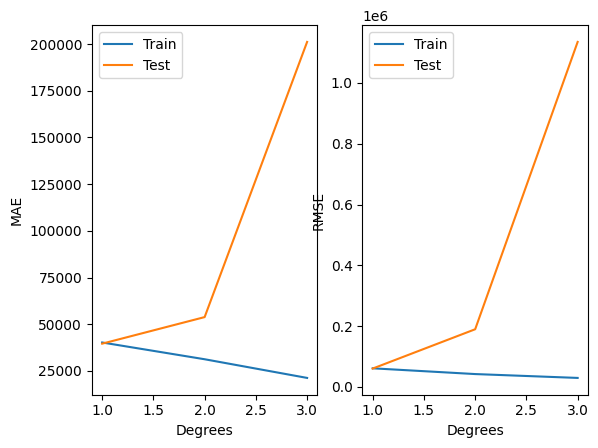

In [ ]:

#Adding in polynomial features
degrees = [1,2,3]
ret,trainMAE,testMAE,trainRMSE,testRMSE = poly_feats(degrees,X_train,X_test,y_train,y_test)

display(pd.DataFrame(ret, columns = ['X split','Degree','MAE','RMSE']))


f,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(degrees,trainMAE,label="Train")
ax1.plot(degrees,testMAE,label="Test")
ax2.plot(degrees,trainRMSE,label="Train")
ax2.plot(degrees,testRMSE,label="Test")

ax1.set_xlabel('Degrees')
ax1.set_ylabel('MAE');
ax2.set_xlabel('Degrees')
ax2.set_ylabel('RMSE');
ax1.legend()
ax2.legend()


In the two cells above we are testing what the impact of adding polynomial features to our dataset to see if it can decrease our test set error values. As we can see in the table and graph above there is no decrease in the MAE or RMSE values which tells us that classifiers would probably do better with a straight linear kernel without any kind of projecting features to higher dimensional spaces.

In [ ]:
def ridge_regress(X_train, X_test, y_train, y_test): 
  #ridge regression
  alphas = np.logspace(-3,3,7)

  #grid search for best alpha value
  param_grid = {
      'alpha': alphas
  }
  ridge_reg = Ridge()
  grid_search = GridSearchCV(ridge_reg, param_grid, cv=5)
  grid_search.fit(X_train, y_train)

  best_alpha = grid_search.best_params_['alpha']


  pipeline = make_pipeline(PolynomialFeatures(3),Ridge(alpha=best_alpha))
  pipeline.fit(np.copy(X_train), np.copy(y_train))

  y_pred = pipeline.predict(X_test)
  print(f'Best parameters: {best_alpha}')

  return mean_absolute_error(y_test, y_pred), mean_squared_error(y_test,y_pred,squared=False)


In [ ]:
#Both
#Testing ridge regression
ridgeData = []
MAE,RMSE = ridge_regress(X_train,X_test,y_train,y_test)
ridgeData.append(["Ridge regression",str(MAE),str(RMSE)])


#Standardization test
MAE, RMSE = ridge_regress(X_train_perFeat,X_test_perFeat,y_train,y_test)
ridgeData.append(["Ridge regression after standardizing individual features ",str(MAE),str(RMSE)])

#SelectFeatures
MAE, RMSE = ridge_regress(X_train_fSelect,X_test_fSelect,y_train,y_test)
ridgeData.append(["Ridge regression after removing features <50 ",str(MAE),str(RMSE)])
MAE, RMSE = ridge_regress(X_train_fSelect2,X_test_fSelect2,y_train,y_test)
ridgeData.append(["Ridge regression after removing features <100 ",str(MAE),str(RMSE)])

display(pd.DataFrame(ridgeData, columns = ['Manipulation performed', 'MAE',"RMSE"]))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Best parameters: 1.0
Best parameters: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Best parameters: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Best parameters: 1.0


,Manipulation performed,MAE,RMSE
0,Ridge regression,110924.00744153047,1945123.59149172
1,Ridge regression after standardizing individua...,73259.3134375208,646681.2169182537
2,Ridge regression after removing features <50,45366.76879544775,119630.44136002545
3,Ridge regression after removing features <100,48473.57350582596,97108.21794461194


Our ridge regression model further confirms our suspicion that polynomial features does not help in providing more accurate results for our dataset. Other models we ran seemed to confirm this as well. Our baseline linear regression model had significantly better accuracy. Our polynomial features testing showed raising the features dimension might not be helpful with our dataset. Also our SVR, with the help of grid search, picked a linear kernel as the best kernel overall. All this combined we made the assumption that a linear classifier would perform best up to this point.

In [ ]:
def support_vector_regression(X_train,X_test,y_train,y_test): 
  #Using standardScalar
  #scaler = StandardScaler()
  #X_train_scaled = scaler.fit_transform(np.copy(X_train))
  #X_test_scaled = scaler.transform(np.copy(X_test))
  #y_train_scaled = scaler.fit_transform(np.copy(y_train).reshape(-1,1))
  #y_test_scaled = scaler.transform(np.copy(y_test).reshape(-1,1))

  svr = SVR()

  param_grid = {
      'kernel': ['linear', 'rbf'],
      'C': [0.1, 1, 10],
      'epsilon': [0.1, 0.2, 0.5]
  }

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  grid_search = GridSearchCV(svr, param_grid, cv=kf, scoring='r2', n_jobs=-1)
  grid_search.fit(X_train, y_train.ravel())

  best_svr = grid_search.best_estimator_
  y_pred = best_svr.predict(X_test)
  #y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))


  print(f'Best estimator: {best_svr}')
  print(f'Best parameters: {grid_search.best_params_}')
  return mean_absolute_error(y_test, y_pred), mean_squared_error(y_test,y_pred,squared=False)

In [ ]:
#Both
#Testing support vector regression
svrData = []
MAE,RMSE = support_vector_regression(X_train,X_test,y_train,y_test)
svrData.append(["support vector regression",str(MAE),str(RMSE)])


#Standardization test
MAE, RMSE = support_vector_regression(X_train_perFeat,X_test_perFeat,y_train,y_test)
svrData.append(["Support vector regression after standardizing individual features ",str(MAE),str(RMSE)])

#SelectFeatures
MAE, RMSE = support_vector_regression(X_train_fSelect,X_test_fSelect,y_train,y_test)
svrData.append(["Support vector regression after removing features <50 ",str(MAE),str(RMSE)])
MAE, RMSE = support_vector_regression(X_train_fSelect2,X_test_fSelect2,y_train,y_test)
svrData.append(["Support vector regression after removing features <100 ",str(MAE),str(RMSE)])

display(pd.DataFrame(svrData, columns = ['Manipulation performed', 'MAE',"RMSE"]))

Best estimator: SVR(C=10, kernel='linear')
Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best estimator: SVR(C=10, kernel='linear')
Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')
Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')
Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}


,Manipulation performed,MAE,RMSE
0,support vector regression,65850.10070679769,95568.95844528942
1,Support vector regression after standardizing ...,69115.53771489729,100858.0638282269
2,Support vector regression after removing featu...,66520.58102791314,95531.73082275839
3,Support vector regression after removing featu...,68459.89674594787,103240.11569835193


Overall the test we performed here did not yield the results we were hoping for. There was a substantial increase in error compared to other classifiers. We believe this accuracy hit comes from not standardizing all the features. This algorithm, based on research we've done, performs better overall if everything is on the same scale, including the label. We chose not to standardize the label because it would throw off the comparisons to the other classifiers. We also believe that the SVR didn't perform as well for the same reason as our ridge classifier. Part of the strength of the SVR is the ability to use kernels to increase dimensionality of the data, in our case this strength was not very helpful which lead to unimpressive results.

In [ ]:
#Random Forests
def Random_forest_regression(X_train,X_test,y_train,y_test): 
  grid = {
    'n_estimators': [10,50,100,200,400], #100,200,500
    'max_features': ['sqrt','log2'],
    'max_depth' : [10,20,30,40,50,60,70], #5,10,20
  }
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  rfGrid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= kf, n_jobs=-1)
  rfGrid.fit(X_train, y_train)
  best_rf = rfGrid.best_estimator_
  y_pred = best_rf.predict(X_test)

  print(f'Best estimator: {best_rf}')
  print(f'Best parameters: {rfGrid.best_params_}')

  return mean_absolute_error(y_test, y_pred), mean_squared_error(y_test,y_pred,squared=False)


In [ ]:
#Both
#Testing random forests
rfData = []
MAE,RMSE = Random_forest_regression(X_train,X_test,y_train,y_test)
rfData.append(["Random forest regression",str(MAE),str(RMSE)])


#Standardization test
MAE, RMSE = Random_forest_regression(X_train_perFeat,X_test_perFeat,y_train,y_test)
rfData.append(["Random forest regression after standardizing individual features ",str(MAE),str(RMSE)])

#SelectFeatures
MAE, RMSE = Random_forest_regression(X_train_fSelect,X_test_fSelect,y_train,y_test)
rfData.append(["Random forest regression after removing features <50 ",str(MAE),str(RMSE)])
MAE, RMSE = Random_forest_regression(X_train_fSelect2,X_test_fSelect2,y_train,y_test)
rfData.append(["Random forest regression after removing features <100 ",str(MAE),str(RMSE)])

display(pd.DataFrame(rfData, columns = ['Manipulation performed', 'MAE',"RMSE"]))

Best estimator: RandomForestRegressor(max_depth=30, max_features='sqrt')
Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
Best estimator: RandomForestRegressor(max_depth=60, max_features='sqrt', n_estimators=50)
Best parameters: {'max_depth': 60, 'max_features': 'sqrt', 'n_estimators': 50}
Best estimator: RandomForestRegressor(max_depth=50, max_features='log2')
Best parameters: {'max_depth': 50, 'max_features': 'log2', 'n_estimators': 100}
Best estimator: RandomForestRegressor(max_depth=20, max_features='sqrt')
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}


,Manipulation performed,MAE,RMSE
0,Random forest regression,38867.563262628064,58671.53461271335
1,Random forest regression after standardizing i...,39331.06920318164,59708.2626498596
2,Random forest regression after removing featur...,39405.96339149019,57614.63509148281
3,Random forest regression after removing featur...,40539.337506998534,58830.1961297093


In the two code cells above we test our data with Random Forest Regression using the sklearn implementation. After performing the previous classifiers and getting underwhelming results due to the dimensionality of our dataset we chose to go a different direction and focus on another linear classifier Random Forests. This was a good classifier for us to hone in on becuase of the potential for getting significant improvements by choosing the different values for the multiple hyperparameters. While it took some time for me to narrow down a good balance between number of estimators and max depth with the grid search, we eventually found a good mix that actually ended up performing better than our linear regression classifier in both MAE and RMSE! This is an exciting result after our strugles with our other classifiers and not only is it out performing but it is significantly out performing the linear classifier consistently, the highest error values for random forest are similar if not lower than our linear regression classifiers lowest errors. We do see the same pattern with the standardization not making mucn difference to error values depending on the split, as well as the feature removal for weights less than 50 being the best performing version of X_train and X_test which enforces our deductions we made in our explanation of the linear regression testing.

**Final Result:**


In the end our random forest classifier ended up performing the best with the lowest MAE and RMSE values across multiple different splits we have tested on. This is due to the versatility of the classifier due to the many hyperparameters and ensemble construction. After we found the right ranges of values for our gridsearch and waited forever for results we noticed significant improvements over all of our other classifiers.


**Our methodology for testing different classifiers:**


Our test procedure involves testing each classifier we used against our raw data with no standardization and no feature selection, standardization of certain features, and selected features. We would then compare the accuracies of each case and determine which cases are most effective for each classifier. Then, we would compare the best accuracies from each classifier to determine which classifier performed the best.


In general, standardizing our features helped slightly for most of our classifiers. Removing features under 50 helped consistently across our classifiers and the impact was noticable. Removing features under 100 did not yield an increase in performance.


**Our though process for choosing classifiers:**

Linear regression was still a prime candidate in this regard and was the first classifier we used and due to it's simplicity we concidered this our baseline model. We also ran this classifier with different versions of X_train and X_test to get a baseline of how these practices would perform on our dataset. Linear regression assumes a linear relationship between the features and the label. With housing, most features like lot size, square footage, etc, usually make for a larger sale price. While it may not be a perfect linear relationship, it should be close.


Our first test after collecting our baselines was to see if we could use polynomial features to raise our data to a higher dimension to increase performance. After running this test we didn't notice any decrease in the test error which lead us to believe that increasing dimensionality might not help much with our dataset.


While Cole tested the polynomial features Alex created the ridge regression classifier to further test if we could gain any performance by increasing dimensionality. This test confirmed along with polynomial features that a linear model was the way to go.


After further research, we decided to try to use support vector regression to tackle our problem. This is similar to an SVM but allows us to use it on a continuous label and seemed interesting enough for us to try. It creates a hyperplane that best fits the data points in a space. Since we went over SVMs in class, we were interested in learning a bit more about SVRs. Although this classifier let us down in performance it was still cool getting to learn about a different version of the SVM.


After this we decided to try another interesting classifier that we knew would perform good against linear data, Random Forest. This ended up being our knight in shining armor that delivered all the performance posibilities we heard in class. It took some significant time to configure the hyperparameters and it takes even longer to train and evaluate but in the end the results speak for themselves.





**What we would do differently:**

For further projects, we would like to do multiple splits either through cross-validation or a for loop to find the average accuracies of our classifiers as this could have an impact on accuracy and would show us a more complete picture of our data. For this project we neglected these processes simply because of the computaion restraints, with our dataset and the classifiers we are using compounded with us choosing to complete the project through Google Collab it was taking too long for us to perform these tests and was leading to unreasonable time for testing our code.



